Final Project.- Training a Machine Learning model on medical images.
CLASS: Artificial Intelligence

GROUP: 003

HOUR: N1

TEAM:

CARLOS ALBERTO SAUCEDO RIOS 1968121
MARIANGELES SOFIA RODRIGUEZ UZCATEGUI 2132315
AMANDA GUADALUPE BUSTOS BANDA 2052995

In [30]:
# -----------------------------
# 1) Import Libraries
# -----------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

Carga de base de datos

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{\r\n  "username": "carlossau1903",\r\n  "key": "KGAT_1d8badb62dbcbfd710bf7e0dee99929a"\r\n}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           2610         43  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000           8612        221  1.0              
kainatjamil12/niteee                                            Netflix Movies and TV Shows Comprehensive Catalogs     1401948  2025-11-19 04:22:09.357000            909         21  1.0              


In [4]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 1.22GB/s]


In [6]:
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d /content/brain_tumor_dataset


In [7]:
!ls /content/brain_tumor_dataset

brain_tumor_dataset  no  yes


In [42]:
# -----------------------------
# 2) Dataset Loading & Preprocessing
# -----------------------------
categories = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
categories.sort()
print("Detected classes:", categories)

IMG_SIZE = 128
X = []
y = []

Detected classes: ['no', 'yes']


Total images loaded: 179
Shape of X: (179, 128, 128, 1), Shape of y: (179,)
Class distribution: Counter({np.int32(0): 92, np.int32(1): 87})


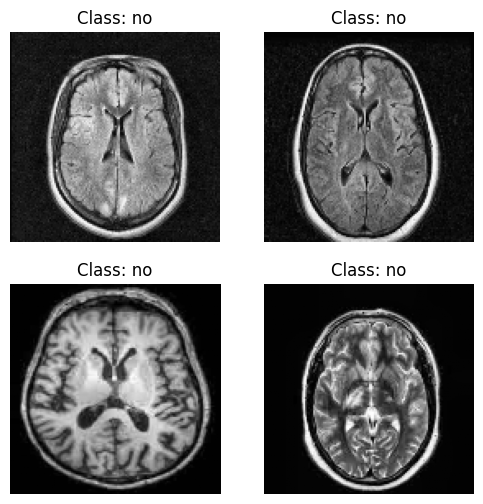

In [43]:
for label, category in enumerate(categories):
    folder = os.path.join(data_path, category)

    # Detect all common image extensions
    images = []
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff'):
        images.extend(glob.glob(os.path.join(folder, ext)))

    if len(images) == 0:
        print(f"Warning: No images found in folder {folder}")
        continue

    for img_file in images:
        try:
            img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            # Resize image
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_clahe = clahe.apply(img_resized)

            # Normalize pixel values
            img_norm = img_clahe / 255.0

            # Add channel dimension
            img_final = np.expand_dims(img_norm, axis=-1)

            X.append(img_final)
            y.append(label)

        except Exception as e:
            print(f"Error processing {img_file}: {e}")

# Convert to numpy arrays
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# Summary
print(f"Total images loaded: {len(X)}")
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
print("Class distribution:", Counter(y))

# Visualize a few sample images
plt.figure(figsize=(6,6))
for i in range(min(4, len(X))):
    plt.subplot(2,2,i+1)
    plt.imshow(X[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Class: {categories[y[i]]}")
    plt.axis('off')
plt.show()

In [44]:
# -----------------------------
# 3) Train-Validation Split (80/20)
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")


Training set: (143, 128, 128, 1), Validation set: (36, 128, 128, 1)


In [45]:
# -----------------------------
# 4) CNN Architecture
# -----------------------------
model = models.Sequential([
    # Conv Block 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE,1)),
    layers.MaxPooling2D((2,2)),

    # Conv Block 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Conv Block 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    # Fully Connected
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(categories), activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# -----------------------------
# 5) Compile CNN
# -----------------------------
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,362 (16.35 MB)

 Trainable params: 4,287,362 (16.35 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# -----------------------------
# 6) Train CNN
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 969ms/step - accuracy: 0.9964 - loss: 0.0114 - val_accuracy: 0.8333 - val_loss: 1.3384
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.7222 - val_loss: 1.4835
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9964 - loss: 0.0122 - val_accuracy: 0.7778 - val_loss: 1.1723
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9964 - loss: 0.0052 - val_accuracy: 0.8333 - val_loss: 1.0882
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7222 - val_loss: 1.3006
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9964 - loss: 0.0066 - val_accuracy: 0.7500 - val_loss: 1.1863
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.7222 - val_loss: 1.6430
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.7222 - val_loss: 1.8497
Epoch 9/15
5/

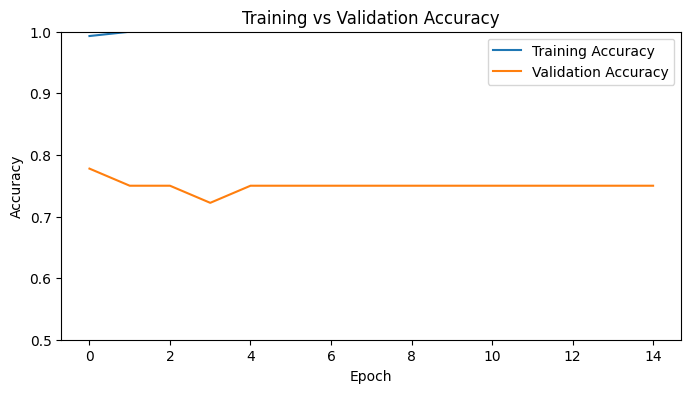

In [59]:
# -----------------------------
# 7) Plot Accuracy vs Validation
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [65]:
# -----------------------------
# 8) Evaluate CNN on Validation
# -----------------------------
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_acc:.4f}")


2/2 - 0s - 174ms/step - accuracy: 0.7222 - loss: 2.1788
Validation Accuracy: 0.7222


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


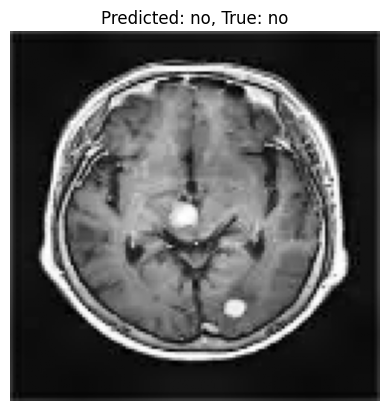

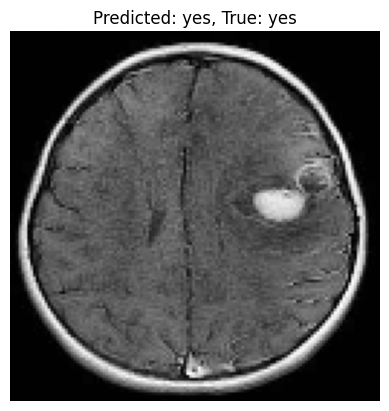

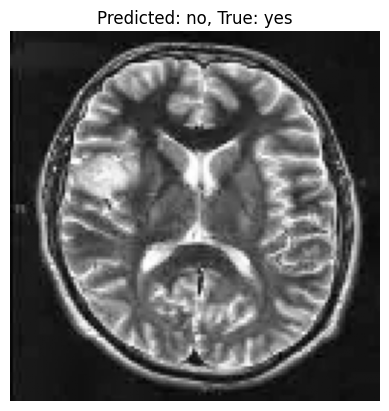

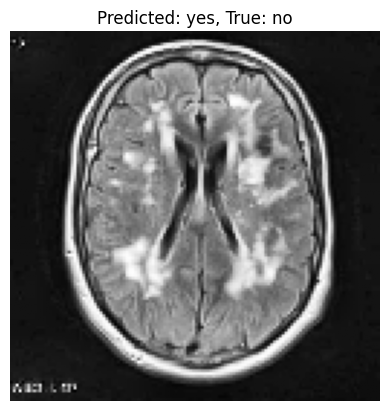

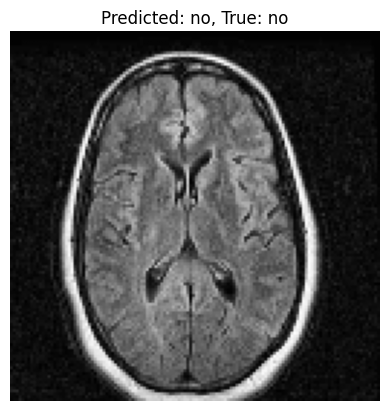

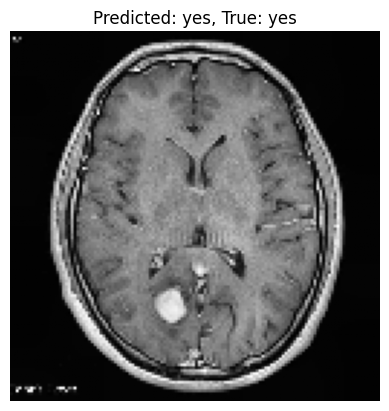

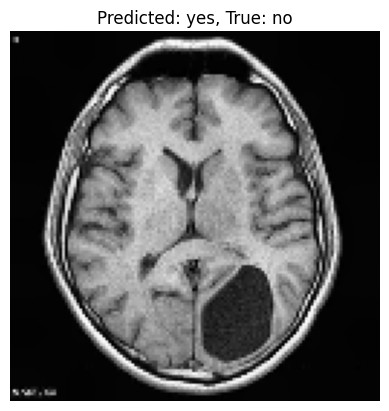

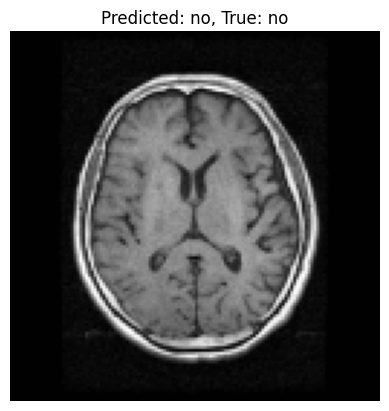

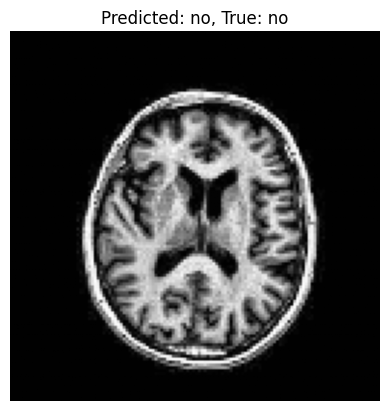

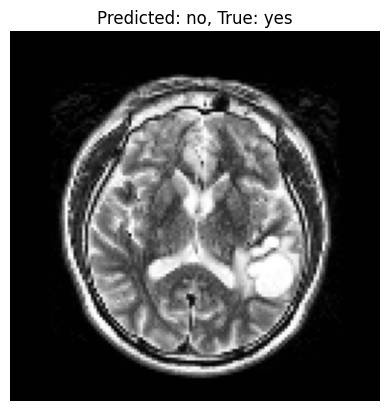

In [66]:
# -----------------------------
# 9) Predictions for 10 Images
# -----------------------------
predictions = model.predict(X_val[:10])
pred_classes = np.argmax(predictions, axis=1)

for i in range(10):
    plt.imshow(X_val[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Predicted: {categories[pred_classes[i]]}, True: {categories[y_val[i]]}")
    plt.axis('off')
    plt.show()